# Cle Elum Ridge "Model" Results with RAPID Data

### Notebook contents 
* Opening all the previous GIS Model result files from snow-off and NCALM
* And opening the new RAPID rasters, and GIS model DCE files 
* Cleaning up the rasters to fit the RAPID domain
* Creating a mask to prevent edge effects on distance to canopy edge
* Save cleaned data to a netcdf file for use later 

created by Cassie Lumbrazo\
date: October 2023\
python environment: **raster**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats
import scipy

In [2]:
# Results from model simulations, reproject match everything to this raster

# SNOWOFF AND NCALM DATA
# snow off and ncalm datasets
tif_dtm_snowoff = rioxarray.open_rasterio("/storage/lumbraca/RAPID/cer_dtm_snowoff_m.tif", masked=True)
tif_dsm_snowoff = rioxarray.open_rasterio("/storage/lumbraca/RAPID/cer_dsm_snowoff_m.tif", masked=True)
tif_dtm_ncalm = rioxarray.open_rasterio("/storage/lumbraca/RAPID/ncalm_dtm.tif", masked=True)
tif_dsm_ncalm = rioxarray.open_rasterio("/storage/lumbraca/RAPID/ncalm_dsm.tif", masked=True)

# previous datasets from ncalm analysis at CER 
tif_aspect = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/cer/cer_aspect.tif", masked=True)
tif_slope = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/cer/cer_slope.tif", masked=True)
tif_dah = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/cer/cer_dah.tif", masked=True)
tif_tpi = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/cer/cer_tpi.tif", masked=True)

# tif_hs_ncalm = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/cer/cer_snowdepth", masked=True) # not loading in snow depth right now
# perhaps consider making it again here with dtms because we want to clean the two snow depth datasets the same 

tif_dce_ncalm = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/cer/cer_dce.tif", masked=True)

tif_chm_snowoff = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/cer/cer_chm_snowoff.tif", masked=True)
tif_chmws_ncalm = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/cer/cer_chmws.tif", masked=True)
tif_chmas_ncalm = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/cer/cer_chmas.tif", masked=True)



# RAPID DATA
# rapid data, different ways the ground points were processed 
tif_dtm_rapid_set1 = rioxarray.open_rasterio("/storage/lumbraca/RAPID/set1/rapid_dtm_minreturn_cloudcompare.tif", masked=True)
tif_dsm_rapid_set1 = rioxarray.open_rasterio("/storage/lumbraca/RAPID/set1/rapid_dsm_cloudcompare.tif", masked=True)

tif_dtm_rapid_set2 = rioxarray.open_rasterio("/storage/lumbraca/RAPID/set2/rapid_dtm_set2.tif", masked=True)
tif_dtm_rapid_set3 = rioxarray.open_rasterio("/storage/lumbraca/RAPID/set3/rapid_dtm_set3.tif", masked=True)


# load all the snow depths calcualted in python in different_dtm_processing.ipynb
tif_hs_rapid_set1 = rioxarray.open_rasterio("/storage/lumbraca/RAPID/set1/hs_rapid_set1_python.tif", masked=True)
tif_hs_rapid_set2 = rioxarray.open_rasterio("/storage/lumbraca/RAPID/set2/hs_rapid_set2_python.tif", masked=True)
tif_hs_rapid_set3 = rioxarray.open_rasterio("/storage/lumbraca/RAPID/set3/hs_rapid_set3_python.tif", masked=True)

# snow depth with masked piles of trees done in arc gis pro
tif_hs_rapid_set2_maskpiles = rioxarray.open_rasterio("/storage/lumbraca/RAPID/set2/hs_rapid_set2_python_maskpiles.tif", masked=True)
tif_hs_rapid_set3_maskpiles = rioxarray.open_rasterio("/storage/lumbraca/RAPID/set3/hs_rapid_set3_python_maskpiles.tif", masked=True)

# chm
tif_chmws_rapid = rioxarray.open_rasterio("/storage/lumbraca/RAPID/chmws_rapid_python.tif", masked=True) # made from set 1 dtm rapid
tif_dce_rapid = rioxarray.open_rasterio("/storage/lumbraca/RAPID/dce_rapid_chmws.tif", masked=True)




# Put it all together 
ds = xr.Dataset({"hs_rapid_set1":tif_hs_rapid_set1, # TO MATCH with 
                 "hs_rapid_set2":tif_hs_rapid_set2.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "hs_rapid_set3":tif_hs_rapid_set3.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "hs_rapid_set2_maskpiles":tif_hs_rapid_set2_maskpiles.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "hs_rapid_set3_maskpiles":tif_hs_rapid_set3_maskpiles.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "chmws_rapid_set1":tif_chmws_rapid.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "dce_rapid":tif_dce_rapid.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),

                 "slope":tif_slope.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "aspect":tif_aspect.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "dah":tif_dah.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "tpi":tif_tpi.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 
                 "chm_snowoff":tif_chm_snowoff.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "chmws_ncalm":tif_chmws_ncalm.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "chmas_ncalm":tif_chmas_ncalm.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "dce_ncalm":tif_dce_ncalm.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),

                 "dtm_snowoff":tif_dtm_snowoff.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "dsm_snowoff":tif_dsm_snowoff.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "dtm_ncalm":tif_dtm_ncalm.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "dsm_ncalm":tif_dsm_ncalm.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "dtm_rapid_set1":tif_dtm_rapid_set1.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "dsm_rapid_set1":tif_dsm_rapid_set1.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "dtm_rapid_set2":tif_dtm_rapid_set2.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),
                 "dtm_rapid_set3":tif_dtm_rapid_set3.rio.reproject_match(tif_hs_rapid_set1, resampling = rasterio.enums.Resampling.bilinear),})

# missing ncalm snow depth 


In [3]:
# close all the datasets to save memory 
# snowoff and ncalm
tif_dtm_snowoff.close()
tif_dsm_snowoff.close()
tif_dtm_ncalm.close()
tif_dsm_ncalm.close()

tif_aspect.close()
tif_slope.close()
tif_dah.close()
tif_tpi.close()

tif_dce_ncalm.close()

tif_chm_snowoff.close()
tif_chmws_ncalm.close()
tif_chmas_ncalm.close()

# rapid data 
tif_dtm_rapid_set1.close()
tif_dsm_rapid_set1.close()
tif_dtm_rapid_set2.close()

tif_hs_rapid_set1.close()
tif_hs_rapid_set2.close()
tif_hs_rapid_set3.close()

tif_hs_rapid_set2_maskpiles.close()
tif_hs_rapid_set3_maskpiles.close()

tif_chmws_rapid.close()
tif_dce_rapid.close()

In [4]:
ds

<xarray.Dataset>
Dimensions:                  (band: 1, x: 2564, y: 1388)
Coordinates:
  * band                     (band) int64 1
  * x                        (x) float64 4.65e+05 4.65e+05 ... 4.676e+05
  * y                        (y) float64 2.111e+05 2.111e+05 ... 2.097e+05
    spatial_ref              int64 0
Data variables: (12/23)
    hs_rapid_set1            (band, y, x) float32 ...
    hs_rapid_set2            (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid_set3            (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid_set2_maskpiles  (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid_set3_maskpiles  (band, y, x) float32 nan nan nan ... nan nan nan
    chmws_rapid_set1         (band, y, x) float32 nan nan nan ... nan nan nan
    ...                       ...
    dtm_ncalm                (band, y, x) float32 3.381e+03 ... 2.898e+03
    dsm_ncalm                (band, y, x) float32 3.424e+03 ... 2.963e+03
    dtm_rapid_set1           (band, y, x) float32 nan nan nan ... nan nan nan
    dsm_rapid_set1           (band, y, x) float32 nan nan nan ... nan nan nan
    dtm_rapid_set2           (band, y, x) float32 nan nan nan ... nan nan nan
    dtm_rapid_set3           (band, y, x) float32 nan nan nan ... nan nan nan

In [5]:
# Because this takes so long to create, let's save all the raw files into a netcdf, before cleaning up the dataset and resaving 
ds.to_netcdf('/home/lumbraca/raster/data/rapid_model_rawdata_create_netcdf.nc')

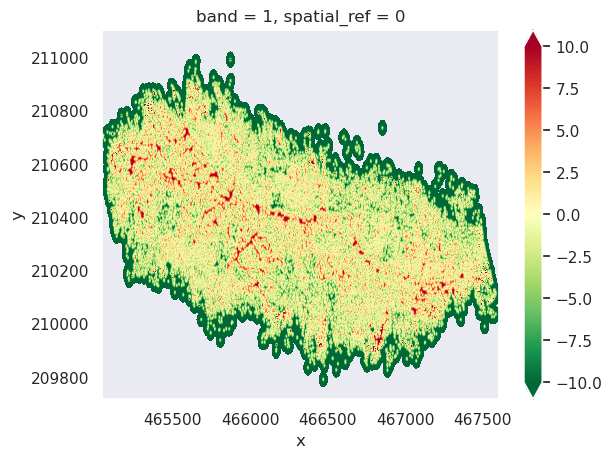

In [6]:
ds.dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

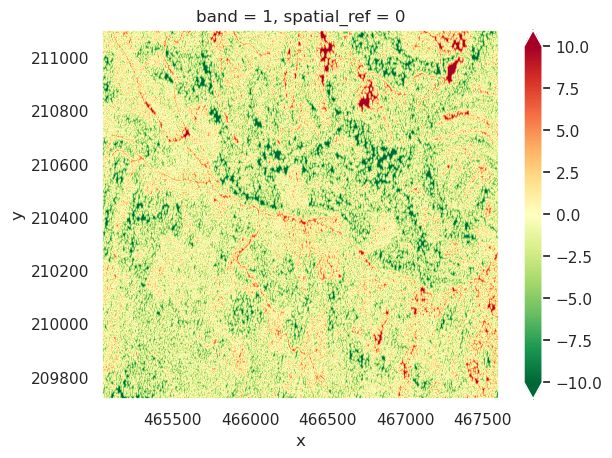

In [7]:
ds.dce_ncalm.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

Compare the two distance to canopy edge files

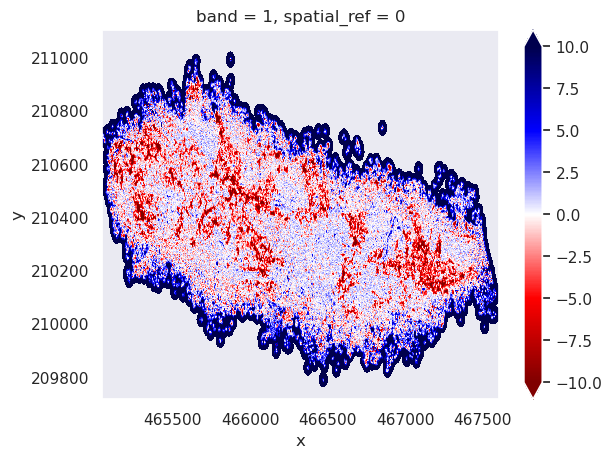

In [8]:
dce_difference = (ds.dce_rapid - ds.dce_ncalm)*-1 
dce_difference.plot(cmap='seismic_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) 

The values for removed trees are negative, because distance to canopy edge is negative into the forest\
So RAPID-NCALM, means the removed trees are negative and thus, we *-1 to make it more intuitive

Everything looks good, there are obvious edge effects on the DCE that is not cleaned so\
now we are ready to move forward with the dataset. 
## Clean up the datasets 

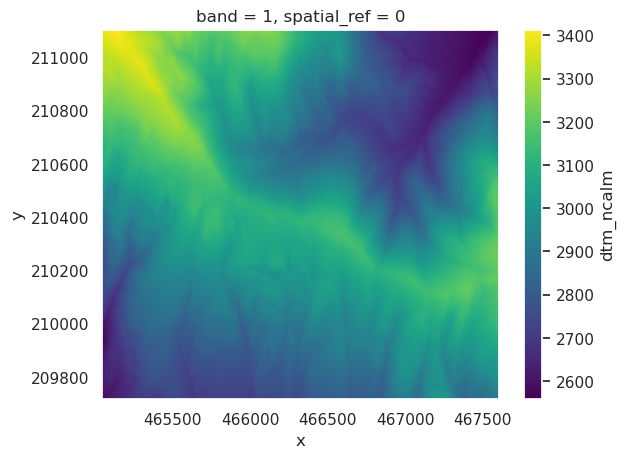

In [9]:
ds.dtm_ncalm.plot()

The NCALM rasters are still in feet, but we already conversted the snow off to meters.

In [10]:
# ncalm dtm and dsm are in feet (already converted snow off to meters)
ds['dtm_ncalm'] = ds['dtm_ncalm']*0.3048
ds['dsm_ncalm'] = ds['dsm_ncalm']*0.3048

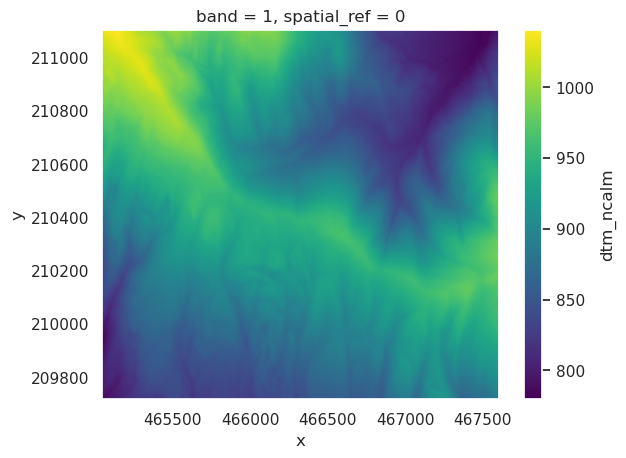

In [11]:
ds.dtm_ncalm.plot()

Okay, now we can calculate snow depth from both dtms in meters.

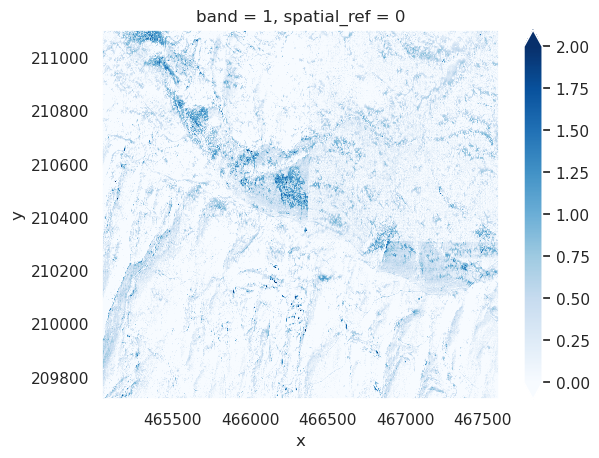

In [12]:
# recalculate snow depth using python for ncalm to match the way it was done for rapid
ds['hs_ncalm'] = ds.dtm_ncalm - ds.dtm_snowoff
ds.hs_ncalm.plot(cmap='Blues', vmin=0, vmax=2, cbar_kwargs={'label':''})

Okay, but we do only want to compare the regions we have data for both.\
Thus, make the entire dataset nan where the values are nan for snow depth for RAPID.\
We will need to redo this at the end after cleaning snow depth.

In [13]:
# make all values of the dataset nan where the values of snow depth are nan 
ds = ds.where(ds.dtm_rapid_set1.notnull())

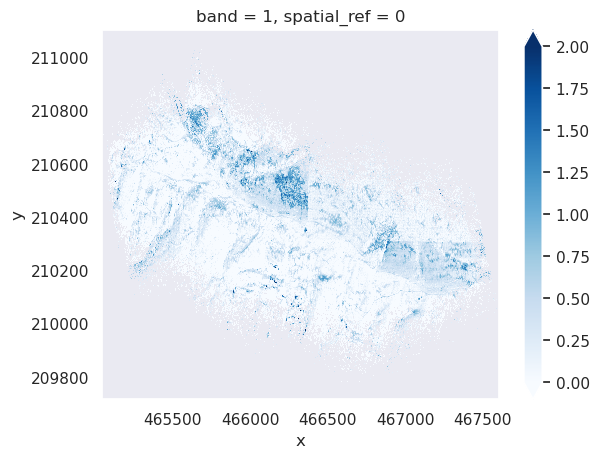

In [14]:
ds.hs_ncalm.plot(cmap='Blues', vmin=0, vmax=2, cbar_kwargs={'label':''})

okay great. Now, we can get to cleaning all different datasets. 

### Remove Outliers 

In [15]:
# the general data for cer  
ds['dem'] = ds['dtm_snowoff'].copy(deep=True) #save dem as a variable 

ds['slope'] = ds['slope'].where(ds['slope'] >= 0, drop=True) # keep slope above 0
ds['aspect'] = ds['aspect'].where(ds['aspect'] >= -1, drop=True) # keep aspect above -1 

ds['tpi'] = ds['tpi'].where(~(ds['tpi'] >  100), drop=True) # removing strange tpi values 
ds['tpi'] = ds['tpi'].where(~(ds['tpi'] < -100), drop=True) # removing strange tpi values 

ds['dah'] = ds['dah'].where(~(ds['dah'] > 50), drop=True) # droping any gaps that are bigger than 50
ds['dah'] = ds['dah'].where(~(ds['dah'] < -50), drop=True) # droping any gaps that are smaller than -50


# clean previous ncalm datasets 
ds['dce_ncalm'] = ds['dce_ncalm'].where(~(ds['dce_ncalm'] > 50), drop=True)  # droping any gaps that are bigger than 50, already cut it to 30 
ds['dce_ncalm'] = ds['dce_ncalm'].where(~(ds['dce_ncalm'] < -50), drop=True) # droping any gaps that are smaller than -50

ds['chm_snowoff'] = ds['chm_snowoff'].where(ds['chm_snowoff'] >= 0, drop=True) # keep canopy height model above 0 
ds['chmws_ncalm'] = ds['chmws_ncalm'].where(ds['chmws_ncalm'] >= 0, drop=True) 
ds['chmas_ncalm'] = ds['chmas_ncalm'].where(ds['chmas_ncalm'] >= 0, drop=True) 

In [16]:
# rapid data 
ds['dce_rapid'] = ds['dce_rapid'].where(~(ds['dce_rapid'] > 50), drop=True)  # droping any gaps that are bigger than 50, already cut it to 30 
ds['dce_rapid'] = ds['dce_rapid'].where(~(ds['dce_rapid'] < -50), drop=True) # droping any gaps that are smaller than -50

ds['chmws_rapid_set1'] = ds['chmws_rapid_set1'].where(ds['chmws_rapid_set1'] >= 0, drop=True) 

# did not create chmas yet, can do that for the final dataset we decide to use for snow depth 
# ds['chmas_rapid'] = ds['chmas_rapid'].where(ds['chmas_rapid'] >= 0, drop=True)
# ^^ did this at the end of the notebook 

Run the first cell below for making all zero snow depth values nan\
and run the second cell instead if you want to account for some negative values being 0 

In [17]:
# # now, rapid snow depth data 
# # # we have the normal snow depth data, if you want to create CUT AT ZERO, use this part of the code 
# ds['hs_rapid_set1'] = ds['hs_rapid_set1'].where(ds['hs_rapid_set1'] >= 0, drop=True)
# ds['hs_rapid_set2'] = ds['hs_rapid_set2'].where(ds['hs_rapid_set2'] >= 0, drop=True)
# ds['hs_rapid_set3'] = ds['hs_rapid_set3'].where(ds['hs_rapid_set3'] >= 0, drop=True)

# # And, regardless of how we remove the negative values, we want to remove all values > 3
# ds['hs_rapid_set1'] = ds['hs_rapid_set1'].where(ds['hs_rapid_set1'] < 3, drop=True)
# ds['hs_rapid_set2'] = ds['hs_rapid_set2'].where(ds['hs_rapid_set2'] < 3, drop=True)
# ds['hs_rapid_set3'] = ds['hs_rapid_set3'].where(ds['hs_rapid_set3'] < 3, drop=True)

# # we also have the masked to remove tree piles datasets 
# ds['hs_rapid_set2_maskpiles'] = ds['hs_rapid_set2_maskpiles'].where(ds['hs_rapid_set2_maskpiles'] >= 0, drop=True)  
# ds['hs_rapid_set3_maskpiles'] = ds['hs_rapid_set3_maskpiles'].where(ds['hs_rapid_set3_maskpiles'] >= 0, drop=True)

# ds['hs_rapid_set2_maskpiles'] = ds['hs_rapid_set2_maskpiles'].where(ds['hs_rapid_set2_maskpiles'] < 3, drop=True)  
# ds['hs_rapid_set3_maskpiles'] = ds['hs_rapid_set3_maskpiles'].where(ds['hs_rapid_set3_maskpiles'] < 3, drop=True)

# # cleaning snow depth ncalm
# ds['hs_ncalm'] = ds['hs_ncalm'].where(ds['hs_ncalm'] >= 0, drop=True)  
# ds['hs_ncalm'] = ds['hs_ncalm'].where(ds['hs_ncalm'] < 3, drop=True) 


Run the cell below to give both NCALM and RAPID 10cm of wiggle room negative 

In [18]:
# now, rapid snow depth data 
# instead of removing everything < 0, we could say if it's between -1 and 0, then make it 0 (accounting for small errors in the data)
# for snow depth, to make small negative values 0 
ds['hs_rapid_set1'] = ds['hs_rapid_set1'].where(ds['hs_rapid_set1'] > -.1, drop=True) # so, start by dropping everything less than -1
ds['hs_rapid_set2'] = ds['hs_rapid_set2'].where(ds['hs_rapid_set2'] > -.1, drop=True)
ds['hs_rapid_set3'] = ds['hs_rapid_set3'].where(ds['hs_rapid_set3'] > -.1, drop=True)

# then, we want to replace everything between -1 and 0 with 0
# xarray.where cond = False, replace with value thus, 
ds['hs_rapid_set1'] = ds['hs_rapid_set1'].where(ds['hs_rapid_set1'] > 0, 0) # then, fill everything less than 0 with 0 (-1 to 0 basically)
ds['hs_rapid_set2'] = ds['hs_rapid_set2'].where(ds['hs_rapid_set2'] > 0, 0) #xarray.where cond = False, replace with value
ds['hs_rapid_set3'] = ds['hs_rapid_set3'].where(ds['hs_rapid_set3'] > 0, 0) #xarray.where cond = False, replace with value

# And, regardless of how we remove the negative values, we want to remove all values > 3
ds['hs_rapid_set1'] = ds['hs_rapid_set1'].where(ds['hs_rapid_set1'] < 3, drop=True) # then, drop everything greater than 3
ds['hs_rapid_set2'] = ds['hs_rapid_set2'].where(ds['hs_rapid_set2'] < 3, drop=True)
ds['hs_rapid_set3'] = ds['hs_rapid_set3'].where(ds['hs_rapid_set3'] < 3, drop=True)

# do the same thing for the other snow depth datasets 
# we also have the masked to remove tree piles datasets 
ds['hs_rapid_set2_maskpiles'] = ds['hs_rapid_set2_maskpiles'].where(ds['hs_rapid_set2_maskpiles'] > -.1, drop=True)  # so, start by dropping everything less than -1
ds['hs_rapid_set3_maskpiles'] = ds['hs_rapid_set3_maskpiles'].where(ds['hs_rapid_set3_maskpiles'] > -.1, drop=True)

ds['hs_rapid_set2_maskpiles'] = ds['hs_rapid_set2_maskpiles'].where(ds['hs_rapid_set2_maskpiles'] > 0, 0)  
ds['hs_rapid_set3_maskpiles'] = ds['hs_rapid_set3_maskpiles'].where(ds['hs_rapid_set3_maskpiles'] > 0, 0)

ds['hs_rapid_set2_maskpiles'] = ds['hs_rapid_set2_maskpiles'].where(ds['hs_rapid_set2_maskpiles'] < 3, drop=True)  
ds['hs_rapid_set3_maskpiles'] = ds['hs_rapid_set3_maskpiles'].where(ds['hs_rapid_set3_maskpiles'] < 3, drop=True)

# Trying with NCALM
ds['hs_ncalm'] = ds['hs_ncalm'].where(ds['hs_ncalm'] > -.1, drop=True)  # only doing the first 30 cm for this one
ds['hs_ncalm'] = ds['hs_ncalm'].where(ds['hs_ncalm'] > 0, 0)  
ds['hs_ncalm'] = ds['hs_ncalm'].where(ds['hs_ncalm'] < 3, drop=True) # cleaning at three since it's the same I did for RAPID

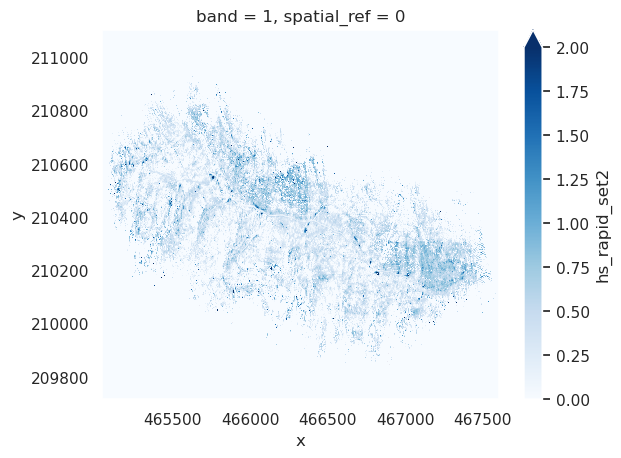

In [19]:
ds.hs_rapid_set2.plot(cmap='Blues', vmin=0, vmax=2)

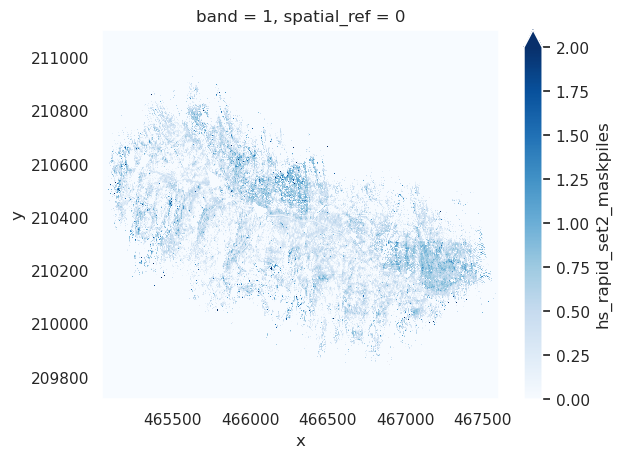

In [20]:
ds.hs_rapid_set2_maskpiles.plot(cmap='Blues', vmin=0, vmax=2)

Okay, so the masked piles certainly look a lot better. We are going to want to move forward with using **hs_rapid_set2_maskedpiles**

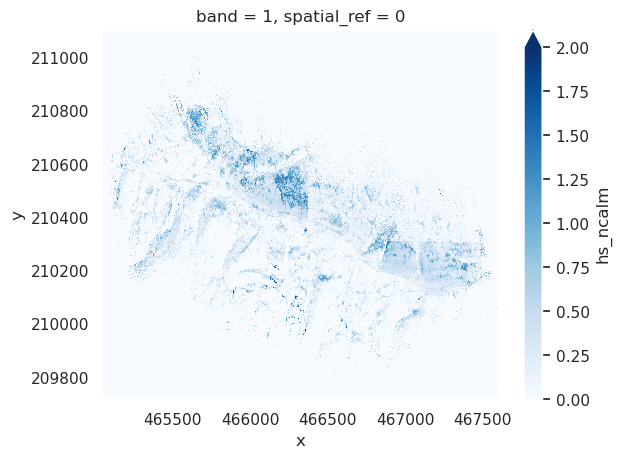

In [21]:
ds.hs_ncalm.plot(cmap='Blues', vmin=0, vmax=2)

In [22]:
print("RAPID Mean:",  ds.hs_rapid_set2_maskpiles.mean().values)
print("RAPID Median:",  ds.hs_rapid_set2_maskpiles.median().values)
print("RAPID STD:",  ds.hs_rapid_set2_maskpiles.std().values)
print('')
print("NCALM Mean:",  ds.hs_ncalm.mean().values)
print("NCALM Median:",  ds.hs_ncalm.median().values)
print("NCALM STD:",  ds.hs_ncalm.std().values)

RAPID Mean: 0.09050196
RAPID Median: 0.0
RAPID STD: 0.20198865

NCALM Mean: 0.07576345
NCALM Median: 0.0
NCALM STD: 0.18315618


(0.0, 1.5)

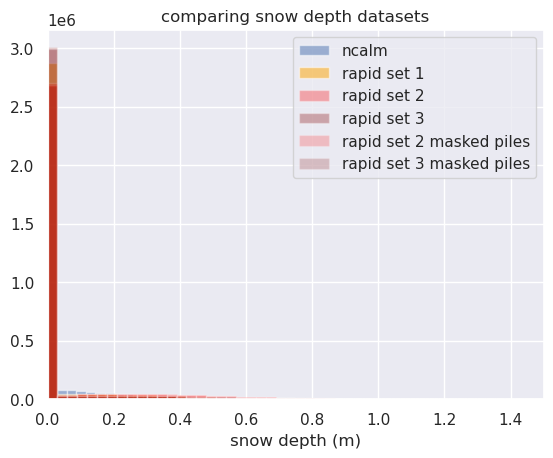

In [23]:
## Create historgrams of all three snow depth datasets together 
ds.hs_ncalm.plot.hist(bins=100, alpha=0.5, label='ncalm')
ds.hs_rapid_set1.plot.hist(bins=100, alpha=0.5, label='rapid set 1', color='orange')
ds.hs_rapid_set2.plot.hist(bins=100, alpha=0.3, label='rapid set 2', color='red')
ds.hs_rapid_set3.plot.hist(bins=100, alpha=0.3, label='rapid set 3', color='maroon')
ds.hs_rapid_set2_maskpiles.plot.hist(bins=100, alpha=0.2, label='rapid set 2 masked piles', color='red')
ds.hs_rapid_set3_maskpiles.plot.hist(bins=100, alpha=0.2, label='rapid set 3 masked piles', color='maroon')
plt.title('comparing snow depth datasets')
plt.xlabel('snow depth (m)')
plt.legend(loc='upper right')
plt.xlim(0,1.5)

So, the masked piles make a very small difference on the distrubitions (which is good)\
It seems we want to use a different method for removing negative snow depths in the RAPID data, so match the distrubition from the ncalm data more\
We can account for some verticle error in the drone, but saying anything ~30cm negative is really zero, or so, and see how it looks

In [24]:
# # testing to see if taking small negative values = 0 in rapid data helps the distribution
# ds.hs_rapid_set2_test = ds.hs_rapid_set2.where(ds.hs_rapid_set2 > 0, other=0)

## Create a buffer on DCE to remove edge effects 

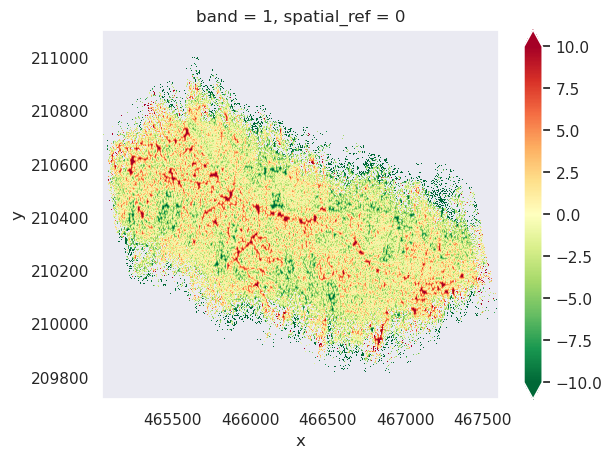

In [25]:
ds.dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

In [26]:
# first creating a binary mask
# if there are values then 1, if not then 0 
dce_mask = ds.dce_rapid.copy(deep=True) # first copy dce 
dce_mask = dce_mask.fillna(-1000) # then filling the nans in the mask with 500 to make this easier
dce_mask = dce_mask.where(dce_mask < -50, 1) # where condition is FALSE, fill with 1 
dce_mask = dce_mask.where(dce_mask > -50, 0) # where condition is FALSE, fill with 0 

# now, we take the dce_mask and do the erosion thing with it to create the fixed mask 
fixed_mask = scipy.ndimage.binary_erosion(dce_mask, structure=np.ones((1,20,20))).astype(dce_mask.dtype) # had to add the 1 to the 50x50 for dimensions

# Perhaps smaller than 20x20 is okay for this dataset? I can go check the dce in ArcGIS Pro to see the distance, and just make sure to write it up.
# I checked, and we really need ~ 20 meters to account for the edge effects in the dce 

# add the fixed mask to the dataset 
ds['mask'] = xr.DataArray(fixed_mask,dims = ['band','y','x'])

# Now, go mask my OG dataset by the fixed_mask to remove the edges of dce 
ds['dce_rapid_raw'] = ds['dce_rapid'].copy(deep=True) # saving dce into a variable for the dataset 
ds['dce_rapid'] = ds['dce_rapid'].where(ds['mask'] >= 1) # resaving the mask dce into dce variable 

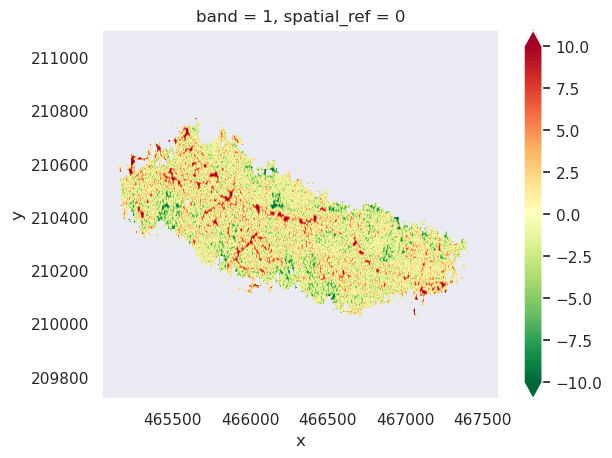

In [27]:
ds.dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

### Set up the different dce classifications 

First, RAPID dataset.

In [28]:
# fix up dah classification for zero to be with negative values
dah_reclass = ds['dah'].copy(deep=True)

dah_reclass = dah_reclass.where(dah_reclass <= 0, 1) # xarray.where cond = False, replace with value
dah_reclass = dah_reclass.where(dah_reclass > 0, -1)

# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['dce_rapid'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 30), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  30)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['dah_reclass'] = dah_reclass.copy(deep=True)
ds['dce_rapid_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
# ds['dce_rapid_largeclusters'] = ds.dce_reclass.where(ds.dce_reclass == 100)
# ds['dce_rapid_smallclusters'] = ds.dce_reclass.where(ds.dce_reclass == 200)
# ds['dce_rapid_canopyedges']   = ds.dce_reclass.where(ds.dce_reclass == 300)
# ds['dce_rapid_smallgaps']     = ds.dce_reclass.where(ds.dce_reclass == 400)
# ds['dce_rapid_largegaps']     = ds.dce_reclass.where(ds.dce_reclass == 500)

Then, NCALM dataset. 

In [29]:
# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['dce_ncalm'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 30), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  30)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['dce_ncalm_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
# ds['dce_ncalm_largeclusters'] = ds.dce_reclass.where(ds.dce_reclass == 100)
# ds['dce_ncalm_smallclusters'] = ds.dce_reclass.where(ds.dce_reclass == 200)
# ds['dce_ncalm_canopyedges']   = ds.dce_reclass.where(ds.dce_reclass == 300)
# ds['dce_ncalm_smallgaps']     = ds.dce_reclass.where(ds.dce_reclass == 400)
# ds['dce_ncalm_largegaps']     = ds.dce_reclass.where(ds.dce_reclass == 500)

## Write to nedcdf 

Need to set everything to null again to make our main snow depth result 

In [30]:
# make all values of the dataset nan where the values of snow depth are nan 
ds = ds.where(ds.hs_rapid_set2_maskpiles.notnull())

# then, save the main snow depth dataset we are going to use for future code 
ds['hs_rapid'] = ds['hs_rapid_set2_maskpiles'].copy(deep=True) # saving dce into a variable for the dataset

# and add the canopy height model above snow to the dataset
ds['chmas_rapid'] = ds['chmws_rapid_set1'] - ds['hs_rapid']

In [31]:
ds

<xarray.Dataset>
Dimensions:                  (band: 1, y: 1388, x: 2564)
Coordinates:
  * band                     (band) int64 1
  * x                        (x) float64 4.65e+05 4.65e+05 ... 4.676e+05
  * y                        (y) float64 2.111e+05 2.111e+05 ... 2.097e+05
    spatial_ref              int64 0
Data variables: (12/32)
    hs_rapid_set1            (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hs_rapid_set2            (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hs_rapid_set3            (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hs_rapid_set2_maskpiles  (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hs_rapid_set3_maskpiles  (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    chmws_rapid_set1         (band, y, x) float32 nan nan nan ... nan nan nan
    ...                       ...
    dce_rapid_raw            (band, y, x) float32 nan nan nan ... nan nan nan
    dah_reclass              (band, y, x) float32 1.0 1.0 1.0 ... 1.0 1.0 1.0
    dce_rapid_reclass        (band, y, x) float32 nan nan nan ... nan nan nan
    dce_ncalm_reclass        (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid                 (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    chmas_rapid              (band, y, x) float32 nan nan nan ... nan nan nan

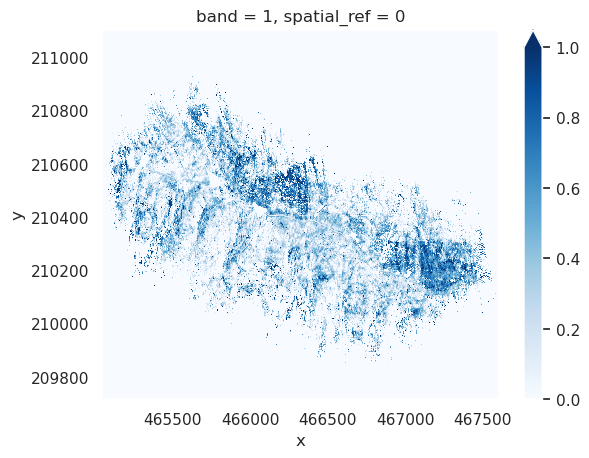

In [32]:
ds['hs_rapid'].plot(cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})

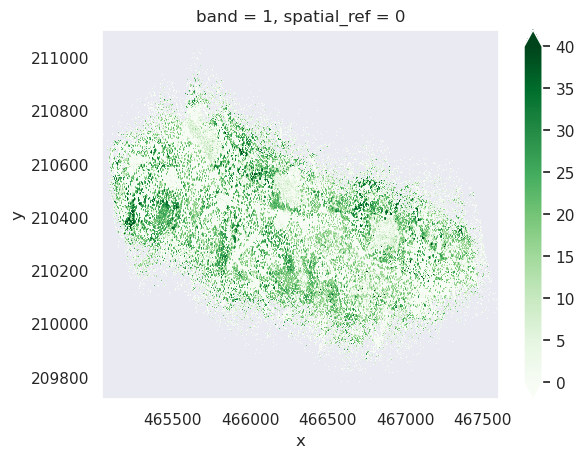

In [36]:
ds['chmas_rapid'].plot(cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''})

In [34]:
# ds.to_netcdf('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_cutatzero.nc') # for the snow depth values cut a zero
ds.to_netcdf('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_negtozero.nc') # for the snow depth values negative to zeros

In [35]:
ds.close()